In [6]:
!git clone https://github.com/joyce2363/BINDREPLICATE.git
!pip install dgl
# !pip install dgl==0.4.3
!pip install torch_geometric
!pip install ipdb
import dgl
from BINDREPLICATE.implementations.utils import load_bail, load_income, load_pokec_renewed
# deleted implementations
from numpy import *
from BINDREPLICATE.implementations.approximator import grad_z_graph, cal_influence_graph, s_test_graph_cost, cal_influence_graph_nodal
# deleted implementations from .approximator
import numpy as np
import scipy.sparse as sp
import torch
from tqdm import tqdm
import pandas as pd
from scipy.spatial import distance_matrix
import os
import networkx as nx
import time
import argparse
from torch_geometric.utils import convert
import warnings
warnings.filterwarnings('ignore')
# import ctypes
# ctypes.cdll.LoadLibrary('caffe2_nvrtc.dll')
torch.backends.cudnn.benchmark = True

fatal: destination path 'BINDREPLICATE' already exists and is not an empty directory.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 19.7 MB/s eta 0:00:00


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Sanity Check: Looking at the dataset we're working with

In [ ]:
import numpy as np
import pandas as pd
dataset = pd.read_csv('BINDREPLICATE/data/bail/bail.csv')
dataset.head()
# pd.read_csv('data.csv')

,WHITE,ALCHY,JUNKY,SUPER,MARRIED,FELON,WORKREL,PROPTY,PERSON,MALE,PRIORS,SCHOOL,RULE,AGE,TSERVD,FOLLOW,RECID,TIME,FILE
0,1,0,0,1,0,0,0,0,0,1,1,8,0,671,1,81,0,0,3
1,1,0,0,1,0,0,0,0,0,1,2,11,0,507,1,80,0,0,3
2,1,1,0,1,1,0,1,0,0,1,0,7,2,441,30,72,0,0,1
3,1,0,0,1,1,0,0,0,0,1,0,11,0,303,4,81,0,0,2
4,1,0,0,0,0,0,1,0,0,1,0,0,3,272,13,76,0,0,3


## 1_training.py (first few lines)

In [ ]:
from __future__ import division
from __future__ import print_function

# import ctypes
# ctypes.cdll.LoadLibrary('caffe2_nvrtc.dll')

from torch_geometric.utils import convert
import time
import argparse
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
# from utils import load_bail, load_income, load_pokec_renewed #deleted implementation.utils
from BINDREPLICATE.implementations.GNNs import GCN #delected implementations.GNNs
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
# import ctypes
# ctypes.cdll.LoadLibrary('caffe2_nvrtc.dll')
# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--fastmode', action='store_true', default=False,
                    help='Validate during training pass.')
parser.add_argument('--dataset', type=str, default="income", help='One dataset from income, bail, pokec1, and pokec2.')
parser.add_argument('--seed', type=int, default=10, help='Random seed.')
parser.add_argument('--epochs', type=int, default=1000,
                    help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.001,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=1e-4,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden units.')
parser.add_argument('--dropout', type=float, default=0.5,
                    help='Dropout rate (1 - keep probability).')

args, unknown = parser.parse_known_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
dataset_name = args.dataset
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
args
# unknown

Namespace(no_cuda=False, fastmode=False, dataset='income', seed=10, epochs=1000, lr=0.001, weight_decay=0.0001, hidden=16, dropout=0.5, cuda=True)

##Utils

In [ ]:
def build_relationship(x, thresh=0.25):
    df_euclid = pd.DataFrame(1 / (1 + distance_matrix(x.T.T, x.T.T)), columns=x.T.columns, index=x.T.columns)
    df_euclid = df_euclid.to_numpy()
    idx_map = []
    for ind in range(df_euclid.shape[0]):
        max_sim = np.sort(df_euclid[ind, :])[-2]
        neig_id = np.where(df_euclid[ind, :] > thresh * max_sim)[0]
        import random
        random.seed(912)
        random.shuffle(neig_id)
        for neig in neig_id:
            if neig != ind:
                idx_map.append([ind, neig])
    idx_map = np.array(idx_map)

    return idx_map

In [ ]:
args

Namespace(no_cuda=False, fastmode=False, dataset='income', seed=10, epochs=1000, lr=0.001, weight_decay=0.0001, hidden=16, dropout=0.5, cuda=True)

In [ ]:
def load_bail(dataset='bail', sens_attr="WHITE", predict_attr="RECID", path="BINDREPLICATE/data", label_number=1000):
    idx_features_labels = pd.read_csv(f'{path}/{dataset}/{dataset}.csv')
# /content/BINDREPLICATE/data/bail/bail.csv
    header = list(idx_features_labels.columns)
    header.remove(predict_attr)

    if os.path.exists(f'{path}/{dataset}_edges.txt'):
        edges_unordered = np.genfromtxt(f'{path}/{dataset}_edges.txt').astype('int')
    else:
        edges_unordered = build_relationship(idx_features_labels[header], thresh=0.6)
        np.savetxt(f'{path}/{dataset}_edges.txt', edges_unordered)

    features = sp.csr_matrix(idx_features_labels[header], dtype=np.float32)
    labels = idx_features_labels[predict_attr].values

    idx = np.arange(features.shape[0])
    idx_map = {j: i for i, j in enumerate(idx)}
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=int).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    adj = adj + sp.eye(adj.shape[0])

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(labels)

    import random
    random.seed(20)
    label_idx_0 = np.where(labels == 0)[0]
    label_idx_1 = np.where(labels == 1)[0]

    random.shuffle(label_idx_0)
    random.shuffle(label_idx_1)

    idx_train = np.append(label_idx_0[:min(int(0.5 * len(label_idx_0)), label_number // 2)],
                          label_idx_1[:min(int(0.5 * len(label_idx_1)), label_number // 2)])
    idx_val = np.append(label_idx_0[int(0.5 * len(label_idx_0)):int(0.75 * len(label_idx_0))],
                        label_idx_1[int(0.5 * len(label_idx_1)):int(0.75 * len(label_idx_1))])
    idx_test = np.append(label_idx_0[int(0.75 * len(label_idx_0)):], label_idx_1[int(0.75 * len(label_idx_1)):])

    sens = idx_features_labels[sens_attr].values.astype(int)
    sens = torch.FloatTensor(sens)
    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)
    # print("adj", adj)
    # print("features", features)
    # print("labels", labels)
    # print("idx_train", idx_train)
    # print("idx_val", idx_val)
    # print("idx_test", idx_test)
    # print("sens", sens)
    return adj, features, labels, idx_train, idx_val, idx_test, sens.to(torch.device('cuda'))
    # adj, features, labels, idx_train, idx_val, idx_test, sens


In [ ]:
def load_income(dataset, sens_attr="race", predict_attr="income", path="/content/BINDREPLICATE/data", label_number=1000):  # 1000
    print('Loading {} dataset from {}'.format(dataset, path))
    idx_features_labels = pd.read_csv(f'{path}/{dataset}/{dataset}.csv')
    header = list(idx_features_labels.columns)
    header.remove(predict_attr)

    if os.path.exists(f'{path}/{dataset}_edges.txt'):
        edges_unordered = np.genfromtxt(f'{path}/{dataset}_edges.txt').astype('int')
    else:
        edges_unordered = build_relationship(idx_features_labels[header], thresh=0.7)
        np.savetxt(f'{path}/{dataset}_edges.txt', edges_unordered)

    features = sp.csr_matrix(idx_features_labels[header], dtype=np.float32)
    labels = idx_features_labels[predict_attr].values
    idx = np.arange(features.shape[0])
    idx_map = {j: i for i, j in enumerate(idx)}
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=int).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    adj = adj + sp.eye(adj.shape[0])

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(labels)

    import random
    random.seed(20)
    label_idx_0 = np.where(labels == 0)[0]
    label_idx_1 = np.where(labels == 1)[0]

    random.shuffle(label_idx_0)
    random.shuffle(label_idx_1)

    idx_train = np.append(label_idx_0[:min(int(0.5 * len(label_idx_0)), label_number // 2)],
                          label_idx_1[:min(int(0.5 * len(label_idx_1)), label_number // 2)])
    idx_val = np.append(label_idx_0[int(0.5 * len(label_idx_0)):int(0.75 * len(label_idx_0))],
                        label_idx_1[int(0.5 * len(label_idx_1)):int(0.75 * len(label_idx_1))])
    idx_test = np.append(label_idx_0[int(0.75 * len(label_idx_0)):], label_idx_1[int(0.75 * len(label_idx_1)):])

    sens = idx_features_labels[sens_attr].values.astype(int)
    sens = torch.FloatTensor(sens)
    #  sens = idx_features_labels[sens_attr].values.astype(int)
    # sens = torch.FloatTensor(sens)
    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test, sens.to(torch.device('cuda'))

loading 'income.csv' check

In [ ]:
# load_income('income')
# /content/BINDREPLICATE/data/income/income.csv

loading 'bail.csv' check

In [ ]:
# load_bail()
# /content/BINDREPLICATE/data/bail/bail.csv

## 1_training.py (rest of the lines)

In [ ]:
# filename = 'income.csv'# Is there a way to not hard code the file name? yes I think I did that
dataset_name = 'income'
# dataset_name = 'bail'
def feature_norm(features):
    min_values = features.min(axis=0)[0]
    max_values = features.max(axis=0)[0]
    return 2*(features - min_values).div(max_values-min_values) - 1

if dataset_name == 'bail':
    adj, features, labels, idx_train, idx_val, idx_test, sens = load_bail('bail')
    norm_features = feature_norm(features)
    norm_features[:, 0] = features[:, 0]
    features = feature_norm(features)
elif dataset_name == 'income':
    adj, features, labels, idx_train, idx_val, idx_test, sens = load_income('income')
    norm_features = feature_norm(features)
    norm_features[:, 8] = features[:, 8]
    features = feature_norm(features)
elif dataset_name == 'pokec1':
    adj, features, labels, idx_train, idx_val, idx_test, sens = load_pokec_renewed(1)
elif dataset_name == 'pokec2':
    adj, features, labels, idx_train, idx_val, idx_test, sens = load_pokec_renewed(2)

edge_index = convert.from_scipy_sparse_matrix(adj)[0]
model = GCN(nfeat=features.shape[1], nhid=args.hidden, nclass=labels.unique().shape[0]-1, dropout=args.dropout)
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

if args.cuda:
    # print("yes CUDA")
    model.cuda()
    features = features.cuda()
    edge_index = edge_index.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

def accuracy_new(output, labels):
    correct = output.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

def fair_metric(pred, labels, sens):
    idx_s0 = sens==0
    idx_s1 = sens==1
    idx_s0_y1 = np.bitwise_and(idx_s0, labels==1)
    idx_s1_y1 = np.bitwise_and(idx_s1, labels==1)
    parity = abs(sum(pred[idx_s0])/sum(idx_s0)-sum(pred[idx_s1])/sum(idx_s1))
    equality = abs(sum(pred[idx_s0_y1])/sum(idx_s0_y1)-sum(pred[idx_s1_y1])/sum(idx_s1_y1))
    return parity.item(), equality.item()

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, edge_index)
    loss_train = F.binary_cross_entropy_with_logits(output[idx_train], labels[idx_train].unsqueeze(1).float())
    preds = (output.squeeze() > 0).type_as(labels)
    acc_train = accuracy_new(preds[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    if not args.fastmode:
        model.eval()
        output = model(features, edge_index)

    loss_val = F.binary_cross_entropy_with_logits(output[idx_val], labels[idx_val].unsqueeze(1).float())
    acc_val = accuracy_new(preds[idx_val], labels[idx_val])
    # print('Epoch: {:04d}'.format(epoch+1),
    #       'loss_train: {:.4f}'.format(loss_train.item()),
    #       'acc_train: {:.4f}'.format(acc_train.item()),
    #       'loss_val: {:.4f}'.format(loss_val.item()),
    #       'acc_val: {:.4f}'.format(acc_val.item()),
    #       'time: {:.4f}s'.format(time.time() - t))

    return loss_val.item()

def tst():
    model.eval()
    output = model(features, edge_index)
    preds = (output.squeeze() > 0).type_as(labels)
    loss_test = F.binary_cross_entropy_with_logits(output[idx_test], labels[idx_test].unsqueeze(1).float())
    acc_test = accuracy_new(preds[idx_test], labels[idx_test])

    print("*****************  Cost  ********************")
    print("SP cost:")
    idx_sens_test = sens[idx_test]
    idx_output_test = output[idx_test]
    print(wasserstein_distance(idx_output_test[idx_sens_test==0].squeeze().cpu().detach().numpy(), idx_output_test[idx_sens_test==1].squeeze().cpu().detach().numpy()))

    print("EO cost:")
    idx_sens_test = sens[idx_test][labels[idx_test]==1]
    idx_output_test = output[idx_test][labels[idx_test]==1]
    print(wasserstein_distance(idx_output_test[idx_sens_test==0].squeeze().cpu().detach().numpy(), idx_output_test[idx_sens_test==1].squeeze().cpu().detach().numpy()))
    print("**********************************************")

    parity, equality = fair_metric(preds[idx_test].cpu().numpy(), labels[idx_test].cpu().numpy(),
                                   sens[idx_test].cpu().numpy())

    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

    print("Statistical Parity:  " + str(parity))
    print("Equality:  " + str(equality))


t_total = time.time()
final_epochs = 0
loss_val_global = 1e10

starting = time.time()
for epoch in tqdm(range(args.epochs)):
    loss_mid = train(epoch)
    if loss_mid < loss_val_global:
        loss_val_global = loss_mid
        torch.save(model, 'gcn_' + dataset_name + '.pth')
        final_epochs = epoch

torch.save(model, 'gcn_' + dataset_name + '.pth')
# print('missing time?')
ending = time.time()
print("Time:", ending - starting, "s")
model = torch.load('gcn_' + dataset_name + '.pth')
tst()

# Example Outcome
# Time: 8.958610534667969 s
# *****************  Cost  ********************
# SP cost:
# 0.7684668737613751
# EO cost:
# 0.9045681932082816
# **********************************************
# Test set results: loss= 0.5638 accuracy= 0.7070
# Statistical Parity:  0.3125430281432843
# Equality:  0.3597688250476939

Loading income dataset from /content/BINDREPLICATE/data


100%|██████████| 1000/1000 [00:05<00:00, 171.42it/s]

Time: 5.840712785720825 s
*****************  Cost  ********************
SP cost:
0.7665371274645056
EO cost:
0.9009179057474404
**********************************************
Test set results: loss= 0.5639 accuracy= 0.7078
Statistical Parity:  0.3154786516823037
Equality:  0.3627538996745595


##2_influence_computation_and_save.py

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default="income", help='One dataset from income, bail, pokec1, and pokec2.')
parser.add_argument('--seed', type=int, default=10, help='Random seed.')
args, unknown = parser.parse_known_args()

dataset_name = args.dataset
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)

In [ ]:
def find123Nei(G, node):
    nodes = list(nx.nodes(G))
    nei1_li = []
    nei2_li = []
    nei3_li = []
    for FNs in list(nx.neighbors(G, node)):
        nei1_li .append(FNs)

    for n1 in nei1_li:
        for SNs in list(nx.neighbors(G, n1)):
            nei2_li.append(SNs)
    nei2_li = list(set(nei2_li) - set(nei1_li))
    if node in nei2_li:
        nei2_li.remove(node)

    for n2 in nei2_li:
        for TNs in nx.neighbors(G, n2):
            nei3_li.append(TNs)
    nei3_li = list(set(nei3_li) - set(nei2_li) - set(nei1_li))
    if node in nei3_li:
        nei3_li.remove(node)

    return nei1_li, nei2_li, nei3_li

def feature_norm(features):
    min_values = features.min(axis=0)[0]
    max_values = features.max(axis=0)[0]
    return 2*(features - min_values).div(max_values-min_values) - 1

def build_relationship(x, thresh=0.25):
    df_euclid = pd.DataFrame(1 / (1 + distance_matrix(x.T.T, x.T.T)), columns=x.T.columns, index=x.T.columns)
    df_euclid = df_euclid.to_numpy()
    idx_map = []
    for ind in range(df_euclid.shape[0]):
        max_sim = np.sort(df_euclid[ind, :])[-2]
        neig_id = np.where(df_euclid[ind, :] > thresh * max_sim)[0]
        import random
        random.seed(912)
        random.shuffle(neig_id)
        for neig in neig_id:
            if neig != ind:
                idx_map.append([ind, neig])
    idx_map = np.array(idx_map)

    return idx_map

def get_adj(dataset_name):
    predict_attr = "RECID"
    if dataset_name == 'bail':
        predict_attr="RECID"
    elif dataset_name == 'income':
        predict_attr = "income"

    if dataset_name == 'pokec1' or dataset_name == 'pokec2':
        if dataset_name == 'pokec1':
            edges = np.load('../data/pokec_dataset/region_job_1_edges.npy')
            labels = np.load('../data/pokec_dataset/region_job_1_labels.npy')
        else:
            edges = np.load('../data/pokec_dataset/region_job_2_2_edges.npy')
            labels = np.load('../data/pokec_dataset/region_job_2_2_labels.npy')

        adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                            shape=(labels.shape[0], labels.shape[0]),
                            dtype=np.float32)
        adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
        return adj

    path="BINDREPLICATE/data/" + str(dataset_name) + "/"
    dataset = dataset_name
    print('Reconstructing the adj of {} dataset...'.format(dataset))
# /content/BINDREPLICATE/data/bail/bail.csv
    idx_features_labels = pd.read_csv(f'{path}/{dataset}.csv')
    header = list(idx_features_labels.columns)
    header.remove(predict_attr)

    if os.path.exists(f'{path}/{dataset}_edges.txt'):
        edges_unordered = np.genfromtxt(f'{path}/{dataset}_edges.txt').astype('int')
    else:
        edges_unordered = build_relationship(idx_features_labels[header], thresh=0.6)
        np.savetxt(f'{path}/{dataset}_edges.txt', edges_unordered)

    features = sp.csr_matrix(idx_features_labels[header], dtype=np.float32)
    labels = idx_features_labels[predict_attr].values

    idx = np.arange(features.shape[0])
    idx_map = {j: i for i, j in enumerate(idx)}
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=int).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    return adj

def del_adj(harmful):
    adj = adj_vanilla
    mask = np.ones(adj.shape[0], dtype=bool)
    mask[harmful] = False
    adj = sp.coo_matrix(adj.tocsr()[mask,:][:,mask])

    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    adj = adj + sp.eye(adj.shape[0])

    return adj

if dataset_name == 'bail':
    model = torch.load('gcn_' + dataset_name + '.pth')
    adj_vanilla, features_vanilla, labels_vanilla, idx_train_vanilla, idx_val_vanilla, idx_test_vanilla, sens_vanilla = load_bail('bail')
    norm_features = feature_norm(features_vanilla)
    norm_features[:, 0] = features_vanilla[:, 0]
    features_vanilla = norm_features
elif dataset_name == 'income':
    model = torch.load('gcn_' + dataset_name + '.pth')
    adj_vanilla, features_vanilla, labels_vanilla, idx_train_vanilla, idx_val_vanilla, idx_test_vanilla, sens_vanilla = load_income('income')
    norm_features = feature_norm(features_vanilla)
    norm_features[:, 8] = features_vanilla[:, 8]
    features_vanilla = norm_features
elif dataset_name == 'pokec1':
    model = torch.load('gcn_' + dataset_name + '.pth')
    adj_vanilla, features_vanilla, labels_vanilla, idx_train_vanilla, idx_val_vanilla, idx_test_vanilla, sens_vanilla = load_pokec_renewed(1)
elif dataset_name == 'pokec2':
    model = torch.load('gcn_' + dataset_name + '.pth')
    adj_vanilla, features_vanilla, labels_vanilla, idx_train_vanilla, idx_val_vanilla, idx_test_vanilla, sens_vanilla = load_pokec_renewed(2)


edge_index = convert.from_scipy_sparse_matrix(adj_vanilla)[0]
print("Pre-processing data...")
computation_graph_involving = []
the_adj = get_adj(dataset_name)
hop = 1
G = nx.Graph(the_adj)
for i in tqdm(range(idx_train_vanilla.shape[0])):
    neighbors = find123Nei(G, idx_train_vanilla[i].item())
    mid = []
    for j in range(hop):
        mid += neighbors[j]
    mid = list(set(mid).intersection(set(idx_train_vanilla.numpy().tolist())))
    computation_graph_involving.append(mid)
print("Pre-processing completed.")

time1 = time.time()
h_estimate_cost = s_test_graph_cost(edge_index, features_vanilla, idx_train_vanilla, idx_test_vanilla, labels_vanilla, sens_vanilla, model, gpu=0)
gradients_list = grad_z_graph(edge_index, features_vanilla, idx_train_vanilla, labels_vanilla, model, gpu=0)
influence, harmful, helpful, harmful_idx, helpful_idx = cal_influence_graph(idx_train_vanilla, h_estimate_cost, gradients_list, gpu=0)
non_iid_influence = []

for i in tqdm(range(idx_train_vanilla.shape[0])):

    if len(computation_graph_involving[i]) == 0:
        non_iid_influence.append(0)
        continue

    reference = list(range(adj_vanilla.shape[0]))
    for j in range(len(reference) - idx_train_vanilla[i]):
        reference[j + idx_train_vanilla[i]] -= 1

    mask = np.ones(idx_train_vanilla.shape[0], dtype=bool)
    mask[i] = False
    idx_train = idx_train_vanilla[mask]
    idx_val = idx_val_vanilla.clone()
    idx_test = idx_test_vanilla.clone()

    idx_train = torch.LongTensor(np.array(reference)[idx_train.numpy()])
    idx_val = torch.LongTensor(np.array(reference)[idx_val.numpy()])
    idx_test = torch.LongTensor(np.array(reference)[idx_test.numpy()])

    computation_graph_involving_copy = computation_graph_involving.copy()
    for j in range(len(computation_graph_involving_copy)):
        computation_graph_involving_copy[j] = np.array(reference)[computation_graph_involving_copy[j]]

    mask = np.ones(labels_vanilla.shape[0], dtype=bool)
    mask[idx_train_vanilla[i]] = False

    features = features_vanilla[mask, :]
    labels = labels_vanilla[mask]
    sens = sens_vanilla[mask]

    adj = del_adj(idx_train_vanilla[i])
    edge_index = convert.from_scipy_sparse_matrix(adj)[0]
    h_estimate_cost_nodal = h_estimate_cost.copy()
    gradients_list_nodal = grad_z_graph(edge_index, features, torch.LongTensor(computation_graph_involving_copy[i]), labels, model, gpu=0)
    influence_nodal, _, _, _, _ = cal_influence_graph_nodal(idx_train, torch.LongTensor(computation_graph_involving_copy[i]), h_estimate_cost_nodal, gradients_list_nodal,
                                                                                gpu=0)
    non_iid_influence.append(sum(influence_nodal))

final_influence = []
for i in range(len(non_iid_influence)):
    ref = [idx_train_vanilla.numpy().tolist().index(item) for item in (computation_graph_involving[i] + [idx_train_vanilla[i]])]
    final_influence.append(non_iid_influence[i] - np.array(influence)[ref].sum())

time4 = time.time()
print("Average time per training node:", (time4 - time1)/1000, "s")
np.save('final_influence_' + dataset_name + '.npy', np.array(final_influence))
# NOTICE: here the helpfulness means the helpfulness to UNFAIRNESS
# print("Helpfulness : ")
# print(final_influence)
# print(np.argsort(final_influence))


# what the output should look like

# Pre-processing data...
# Reconstructing the adj of income dataset...
# 100%|██████████| 1000/1000 [00:00<00:00, 1808.32it/s]
# Pre-processing completed.
# 100%|██████████| 1000/1000 [05:46<00:00,  2.89it/s]
# Average time per training node: 0.3576169583797455 s

Loading income dataset from /content/BINDREPLICATE/data
Pre-processing data...
Reconstructing the adj of income dataset...


100%|██████████| 1000/1000 [00:01<00:00, 518.63it/s]


Pre-processing completed.


100%|██████████| 1000/1000 [07:03<00:00,  2.36it/s]


Average time per training node: 0.44552753448486326 s


## 3_removing_and_testing.py

In [ ]:
from __future__ import division
from __future__ import print_function

from BINDREPLICATE.implementations.approximator import wasserstein_cost_loss
from sklearn.metrics import roc_auc_score, f1_score
import torch.nn.functional as F
import torch.optim as optim
from scipy.stats import wasserstein_distance


In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--fastmode', action='store_true', default=False,
                    help='Validate during training pass.')
parser.add_argument('--dataset', type=str, default="bail", help='One dataset from income, bail, pokec1, and pokec2.')
parser.add_argument('--seed', type=int, default=10, help='Random seed.')
parser.add_argument('--epochs', type=int, default=30,
                    help='Number of epochs to continue training for estimation evaluation.')
parser.add_argument('--lr', type=float, default=0.01,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=0,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden units.')
parser.add_argument('--dropout', type=float, default=0.5,
                    help='Dropout rate (1 - keep probability).')
parser.add_argument('--helpfulness_collection', type=int, default=1,
                    help='do leave-one-out for helpful nodes.')

args, unknown = parser.parse_known_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
dataset_name = args.dataset
open_factor = args.helpfulness_collection
print("open_factor: ", open_factor)

def accuracy_new(output, labels):
    correct = output.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

def build_relationship(x, thresh=0.25):
    df_euclid = pd.DataFrame(1 / (1 + distance_matrix(x.T.T, x.T.T)), columns=x.T.columns, index=x.T.columns)
    df_euclid = df_euclid.to_numpy()
    idx_map = []
    for ind in range(df_euclid.shape[0]):
        max_sim = np.sort(df_euclid[ind, :])[-2]
        neig_id = np.where(df_euclid[ind, :] > thresh * max_sim)[0]
        import random
        random.seed(912)
        random.shuffle(neig_id)
        for neig in neig_id:
            if neig != ind:
                idx_map.append([ind, neig])
    idx_map = np.array(idx_map)

    return idx_map

def normalize(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def get_adj(dataset_name):
    predict_attr = "RECID"
    if dataset_name == 'bail':
        predict_attr="RECID"
    elif dataset_name == 'income':
        predict_attr = "income"

    if dataset_name == 'pokec1' or dataset_name == 'pokec2':
        if dataset_name == 'pokec1':
            edges = np.load('../data/pokec_dataset/region_job_1_edges.npy')
            labels = np.load('../data/pokec_dataset/region_job_1_labels.npy')
        else:
            edges = np.load('../data/pokec_dataset/region_job_2_2_edges.npy')
            labels = np.load('../data/pokec_dataset/region_job_2_2_labels.npy')

        adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                            shape=(labels.shape[0], labels.shape[0]),
                            dtype=np.float32)
        adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
        return adj

#  path="BINDREPLICATE/data/" + str(dataset_name) + "/"
#     dataset = dataset_name
#     print('Reconstructing the adj of {} dataset...'.format(dataset))
# # /content/BINDREPLICATE/data/bail/bail.csv
#     idx_features_labels = pd.read_csv(f'{path}/bail.csv')
#     header = list(idx_features_labels.columns)
#     header.remove(predict_attr)


    path="BINDREPLICATE/data/" + str(dataset_name) + "/"
    dataset = dataset_name
    print('Reconstructing the adj of {} dataset...'.format(dataset))
    idx_features_labels = pd.read_csv(f'{path}/bail.csv')
    header = list(idx_features_labels.columns)
    header.remove(predict_attr)
    if os.path.exists(f'{path}/{dataset}_edges.txt'):
        edges_unordered = np.genfromtxt(f'{path}/{dataset}_edges.txt').astype('int')
    else:
        edges_unordered = build_relationship(idx_features_labels[header], thresh=0.6)
        np.savetxt(f'{path}/{dataset}_edges.txt', edges_unordered)

    features = sp.csr_matrix(idx_features_labels[header], dtype=np.float32)
    labels = idx_features_labels[predict_attr].values

    idx = np.arange(features.shape[0])
    idx_map = {j: i for i, j in enumerate(idx)}
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=int).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    return adj

def del_adj(harmful, dataset_name):
    predict_attr = "RECID"

    if dataset_name == 'bail':
        predict_attr="RECID"
    elif dataset_name == 'income':
        predict_attr = "income"

    if dataset_name == 'pokec1' or dataset_name == 'pokec2':
        if dataset_name == 'pokec1':
            edges = np.load('../data/pokec_dataset/region_job_1_edges.npy')
            labels = np.load('../data/pokec_dataset/region_job_1_labels.npy')
        else:
            edges = np.load('../data/pokec_dataset/region_job_2_2_edges.npy')
            labels = np.load('../data/pokec_dataset/region_job_2_2_labels.npy')

        adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                            shape=(labels.shape[0], labels.shape[0]),
                            dtype=np.float32)
        mask = np.ones(adj.shape[0], dtype=bool)
        mask[harmful] = False
        adj = sp.coo_matrix(adj.tocsr()[mask, :][:, mask])
        # build symmetric adjacency matrix
        adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
        adj = adj + sp.eye(adj.shape[0])
        return adj
# /content/BINDREPLICATE/data/bail/bail.csv
    path="BINDREPLICATE/data/" + str(dataset_name) + "/"
    dataset = dataset_name
    idx_features_labels = pd.read_csv(os.path.join(path, "{}.csv".format(dataset)))
    header = list(idx_features_labels.columns)
    header.remove(predict_attr)

    adj = adj_ori
    mask = np.ones(adj.shape[0], dtype=bool)
    mask[harmful] = False
    adj = sp.coo_matrix(adj.tocsr()[mask,:][:,mask])

    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    adj = adj + sp.eye(adj.shape[0])

    return adj

def find123Nei(G, node):
    nodes = list(nx.nodes(G))
    nei1_li = []
    nei2_li = []
    nei3_li = []
    for FNs in list(nx.neighbors(G, node)):
        nei1_li .append(FNs)

    for n1 in nei1_li:
        for SNs in list(nx.neighbors(G, n1)):
            nei2_li.append(SNs)
    nei2_li = list(set(nei2_li) - set(nei1_li))
    if node in nei2_li:
        nei2_li.remove(node)

    for n2 in nei2_li:
        for TNs in nx.neighbors(G, n2):
            nei3_li.append(TNs)
    nei3_li = list(set(nei3_li) - set(nei2_li) - set(nei1_li))
    if node in nei3_li:
        nei3_li.remove(node)

    return [nei1_li, nei2_li, nei3_li]

def feature_norm(features):
    min_values = features.min(axis=0)[0]
    max_values = features.max(axis=0)[0]
    return 2*(features - min_values).div(max_values-min_values) - 1

if dataset_name == 'bail':
    adj, features, labels, idx_train, idx_val, idx_test, sens = load_bail('bail')
    norm_features = feature_norm(features)
    norm_features[:, 0] = features[:, 0]
    features = feature_norm(features)
elif dataset_name == 'income':
    adj, features, labels, idx_train, idx_val, idx_test, sens = load_income('income')
    norm_features = feature_norm(features)
    norm_features[:, 8] = features[:, 8]
    features = feature_norm(features)
elif dataset_name == 'pokec1':
    adj, features, labels, idx_train, idx_val, idx_test, sens = load_pokec_renewed(1)
elif dataset_name == 'pokec2':
    adj, features, labels, idx_train, idx_val, idx_test, sens = load_pokec_renewed(2)

edge_index = convert.from_scipy_sparse_matrix(adj)[0]
computation_graph_involving = []
the_adj = get_adj(dataset_name)
hop = 1
print("Finding neighbors ... ")
G = nx.Graph(the_adj)
for i in tqdm(range(idx_train.shape[0])):
    neighbors = find123Nei(G, idx_train[i].item())
    mid = []
    for j in range(hop):
        mid += neighbors[j]
    mid = list(set(mid).intersection(set(idx_train.numpy().tolist()))) + [idx_train[i].item()]
    computation_graph_involving.append(mid)

final_influence = np.load('final_influence_' + dataset_name + '.npy', allow_pickle=True)
helpful = idx_train[np.argsort(final_influence).copy()].tolist()
helpful_idx = np.argsort(final_influence).copy().tolist()
harmful_idx = helpful_idx[::-1]
harmful = idx_train[harmful_idx].tolist()

if open_factor:
    harmful = helpful
    harmful_idx = helpful_idx

total_neighbors = []
masker = np.ones(len(harmful), dtype=bool)
for i in range(len(harmful) - 1):
    if masker[i] == True:
        total_neighbors += computation_graph_involving[harmful_idx[i]]
    if list(set(total_neighbors).intersection(set(computation_graph_involving[harmful_idx[i + 1]]))) != []:  # != [] 找的是nonoverlapping的
        masker[i+1] = False

harmful_idx = np.array(harmful_idx)[masker].tolist()
harmful = idx_train[harmful_idx].tolist()

max_num = 0
for i in range(len(final_influence[harmful_idx]) - 1):
    if final_influence[harmful_idx][i] * final_influence[harmful_idx][i+1] <= 0:
        print("At most effective number:")
        print(i + 1)
        max_num = i + 1
        break

def fair_metric(pred, labels, sens):
    idx_s0 = sens==0
    idx_s1 = sens==1
    idx_s0_y1 = np.bitwise_and(idx_s0, labels==1)
    idx_s1_y1 = np.bitwise_and(idx_s1, labels==1)
    parity = abs(sum(pred[idx_s0])/sum(idx_s0)-sum(pred[idx_s1])/sum(idx_s1))
    equality = abs(sum(pred[idx_s0_y1])/sum(idx_s0_y1)-sum(pred[idx_s1_y1])/sum(idx_s1_y1))

    return parity.item(), equality.item()


def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, edge_index)
    loss_train = F.binary_cross_entropy_with_logits(output[idx_train], labels[idx_train].unsqueeze(1).float())
    preds = (output.squeeze() > 0).type_as(labels)
    acc_train = accuracy_new(preds[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    if not args.fastmode:
        model.eval()
        output = model(features, edge_index)

    loss_val = F.binary_cross_entropy_with_logits(output[idx_val], labels[idx_val].unsqueeze(1).float())
    acc_val = accuracy_new(preds[idx_val], labels[idx_val])
    # print('Epoch: {:04d}'.format(epoch+1),
    #       'loss_train: {:.4f}'.format(loss_train.item()),
    #       'acc_train: {:.4f}'.format(acc_train.item()),
    #       'loss_val: {:.4f}'.format(loss_val.item()),
    #       'acc_val: {:.4f}'.format(acc_val.item()),
    #       'time: {:.4f}s'.format(time.time() - t))
    # print(wasserstein_cost_loss(output[idx_test], sens[idx_test]))

    return loss_val.item()


def tst():
    model.eval()
    output = model(features, edge_index)
    preds = (output.squeeze() > 0).type_as(labels)
    loss_test = F.binary_cross_entropy_with_logits(output[idx_test], labels[idx_test].unsqueeze(1).float())
    acc_test = accuracy_new(preds[idx_test], labels[idx_test])

    idx_sens_test = sens[idx_test]
    idx_output_test = output[idx_test]
    fair_cost_records.append(wasserstein_distance(idx_output_test[idx_sens_test==0].squeeze().cpu().detach().numpy(), idx_output_test[idx_sens_test==1].squeeze().cpu().detach().numpy()))

    auc_roc_test = roc_auc_score(labels[idx_test].cpu().numpy(), output[idx_test].detach().cpu().numpy())
    f1_test = f1_score(labels[idx_test].cpu().numpy(), preds[idx_test].cpu().numpy())
    parity, equality = fair_metric(preds[idx_test].cpu().numpy(), labels[idx_test].cpu().numpy(),
                                   sens[idx_test].cpu().numpy())

    sp_records.append(parity)
    eo_records.append(equality)
    acc_records.append(acc_test.item())
    auc_records.append(auc_roc_test)
    f1_records.append(f1_test)


if dataset_name == 'bail':
    adj_ori, features_ori, labels_ori, idx_train_ori, idx_val_ori, idx_test_ori, sens_ori = load_bail('bail')
    norm_features_ori = feature_norm(features_ori)
    norm_features_ori[:, 0] = features_ori[:, 0]
    features_ori = feature_norm(features_ori)
elif dataset_name == 'income':
    adj_ori, features_ori, labels_ori, idx_train_ori, idx_val_ori, idx_test_ori, sens_ori = load_income('income')
    norm_features_ori = feature_norm(features_ori)
    norm_features_ori[:, 8] = features_ori[:, 8]
    features_ori = feature_norm(features_ori)
elif dataset_name == 'pokec1':
    adj_ori, features_ori, labels_ori, idx_train_ori, idx_val_ori, idx_test_ori, sens_ori = load_pokec_renewed(1)
elif dataset_name == 'pokec2':
    adj_ori, features_ori, labels_ori, idx_train_ori, idx_val_ori, idx_test_ori, sens_ori = load_pokec_renewed(2)

edge_index_ori = convert.from_scipy_sparse_matrix(adj_ori)[0]

influence_approximation = []
fair_cost_records = []
sp_records = []
eo_records = []
acc_records = []
auc_records = []
f1_records = []

batch_size = 1
percetage_budget = 0.3


for num_of_deleting in tqdm(range(int(percetage_budget * max_num//batch_size) + 1)):

    adj, features, labels, idx_train, idx_val, idx_test, sens = adj_ori, features_ori.clone(), labels_ori.clone(), idx_train_ori.clone(), idx_val_ori.clone(), idx_test_ori.clone(), sens_ori.clone()
    bin = num_of_deleting
    k = int(batch_size * bin)
    harmful_flags = harmful[:k]

    influence_approximation.append(sum(final_influence[harmful_idx[:k]]))
    harmful_idx_flags = harmful_idx[:k]
    mask = np.ones(idx_train.shape[0], dtype=bool)
    mask[harmful_idx_flags] = False
    idx_train = idx_train[mask]
    idx_val = idx_val.clone()
    idx_test = idx_test.clone()

    reference = list(range(adj.shape[0]))
    for i in range(len(harmful_flags)):
        for j in range(len(reference) - harmful_flags[i]):
            reference[j + harmful_flags[i]] -= 1

    idx_train = torch.LongTensor(np.array(reference)[idx_train.numpy()])
    idx_val = torch.LongTensor(np.array(reference)[idx_val.numpy()])
    idx_test = torch.LongTensor(np.array(reference)[idx_test.numpy()])

    mask = np.ones(labels.shape[0], dtype=bool)
    mask[harmful_flags] = False
    features = features[mask, :]
    labels = labels[mask]
    sens = sens[mask]

    adj = del_adj(harmful_flags, dataset_name)
    edge_index = convert.from_scipy_sparse_matrix(adj)[0]
    model = torch.load('gcn_' + dataset_name + '.pth')
    optimizer = optim.Adam(model.parameters(),
                           lr=args.lr, weight_decay=args.weight_decay)

    if args.cuda:
        model.cuda()
        features = features.cuda()
        edge_index = edge_index.cuda()
        labels = labels.cuda()
        idx_train = idx_train.cuda()
        idx_val = idx_val.cuda()
        idx_test = idx_test.cuda()

    final_epochs = -1
    loss_val_global = 1e10

    for epoch in range(args.epochs):
        loss_mid = train(epoch)
        if loss_mid < loss_val_global:
            loss_val_global = loss_mid
            torch.save(model, 'mid_best' + str(bin) + '.pth')
            final_epochs = epoch

    if final_epochs == -1:
        assert 1 == 0

    model = torch.load('mid_best' + str(bin) + '.pth')
    tst()
    os.remove('mid_best' + str(bin) + '.pth')

final_sets = {}
final_sets['influence_approximation'] = influence_approximation
final_sets['fair_cost_records'] = fair_cost_records
final_sets['sp_records'] = sp_records
final_sets['eo_records'] = eo_records
final_sets['acc_records'] = acc_records
final_sets['auc_records'] = auc_records
final_sets['f1_records'] = f1_records

if open_factor:
    np.save('1final_sets_' + dataset_name + '.npy', final_sets)
else:
    np.save('imp_final_sets_' + dataset_name + '.npy', final_sets)

#expected output example
# 0
# Loading income dataset from ../data/income/
# Reconstructing the adj of income dataset...
# Finding neighbors ...
# 100%|██████████| 1000/1000 [00:00<00:00, 1716.26it/s]
# At most effective number:
# 327
# Loading income dataset from ../data/income/
# 100%|██████████| 99/99 [00:36<00:00,  2.73it/s]

open_factor:  1
Reconstructing the adj of bail dataset...
Finding neighbors ... 


100%|██████████| 1000/1000 [00:55<00:00, 18.01it/s]


At most effective number:
375


100%|██████████| 113/113 [00:49<00:00,  2.26it/s]


## approximator.py

In [ ]:
# import torch
from torch.autograd import grad
import torch.nn.functional as F
# import numpy as np
import random
from torch.linalg import det

def pdist(sample_1, sample_2, norm=2, eps=1e-5):
    n_1, n_2 = sample_1.size(0), sample_2.size(0)
    norm = float(norm)
    if norm == 2.:
        norms_1 = torch.sum(sample_1**2, dim=1, keepdim=True)
        norms_2 = torch.sum(sample_2**2, dim=1, keepdim=True)
        norms = (norms_1.expand(n_1, n_2) +
                 norms_2.transpose(0, 1).expand(n_1, n_2))
        distances_squared = norms - 2 * sample_1.mm(sample_2.t())
        return torch.sqrt(eps + torch.abs(distances_squared))
    else:
        dim = sample_1.size(1)
        expanded_1 = sample_1.unsqueeze(1).expand(n_1, n_2, dim)
        expanded_2 = sample_2.unsqueeze(0).expand(n_1, n_2, dim)
        differences = torch.abs(expanded_1 - expanded_2) ** norm
        inner = torch.sum(differences, dim=2, keepdim=False)
        return (eps + inner) ** (1. / norm)

def wasserstein(x, y, device, p=0.5, lam=10, its=10, sq=False, backpropT=False, cuda=True):
    nx = x.shape[0]
    ny = y.shape[0]

    M = pdist(x, y)
    M_mean = torch.mean(M)
    M_drop = F.dropout(M, 10.0 / (nx * ny))
    delta = torch.max(M_drop).cpu().detach()
    eff_lam = (lam / M_mean).cpu().detach()

    Mt = M
    row = delta * torch.ones(M[0:1, :].shape)
    col = torch.cat([delta * torch.ones(M[:, 0:1].shape), torch.zeros((1, 1))], 0)
    if cuda:
        #row = row.cuda()
        #col = col.cuda()
        row = row.to(device)
        col = col.to(device)
    Mt = torch.cat([M, row], 0)
    Mt = torch.cat([Mt, col], 1)

    a = torch.cat([p * torch.ones((nx, 1)) / nx, (1 - p) * torch.ones((1, 1))], 0)
    b = torch.cat([(1 - p) * torch.ones((ny, 1)) / ny, p * torch.ones((1, 1))], 0)

    Mlam = eff_lam * Mt
    temp_term = torch.ones(1) * 1e-6
    if cuda:
        temp_term = temp_term.to(device)
        a = a.to(device)
        b = b.to(device)
    K = torch.exp(-Mlam) + temp_term
    U = K * Mt
    ainvK = K / a
    u = a
    for i in range(its):
        u = 1.0 / (ainvK.matmul(b / torch.t(torch.t(u).matmul(K))))
        if cuda:
            u = u.to(device)
    v = b / (torch.t(torch.t(u).matmul(K)))
    if cuda:
        v = v.to(device)

    upper_t = u * (torch.t(v) * K).detach()
    E = upper_t * Mt
    D = 2 * torch.sum(E)
    if cuda:
        D = D.to(device)

    return D

def cof1(M,index):
    zs = M[:index[0]-1,:index[1]-1]
    ys = M[:index[0]-1,index[1]:]
    zx = M[index[0]:,:index[1]-1]
    yx = M[index[0]:,index[1]:]
    s = torch.cat((zs,ys),axis=1)
    x = torch.cat((zx,yx),axis=1)
    return det(torch.cat((s,x),axis=0))

def alcof(M,index):
    return pow(-1,index[0]+index[1])*cof1(M,index)

def adj(M):
    result = torch.zeros((M.shape[0],M.shape[1]))
    for i in range(1,M.shape[0]+1):
        for j in range(1,M.shape[1]+1):
            result[j-1][i-1] = alcof(M,[i,j])
    return result

def invmat(M):
    return 1.0/det(M)*adj(M)

def random_int_list(start, stop, length):
    start, stop = (int(start), int(stop)) if start <= stop else (int(stop), int(start))
    length = int(abs(length)) if length else 0
    random_list = []
    for i in range(length):
        random_list.append(random.randint(start, stop))
    return random_list

def wasserstein_cost_loss(output, sens):

    group_1_diff = output[sens==1]
    group_0_diff = output[sens==0]

    return wasserstein(group_0_diff, group_1_diff, 'cuda')

def grad_z_graph_faircost(adj, features, idx, labels, sens, model, gpu=-1):
    model.eval()
    # initialize
    if gpu >= 0:
        adj, features, labels = adj.cuda(), features.cuda(), labels.cuda()
    if gpu < 0:
        adj, features, labels, model = adj.cpu(), features.cpu(), labels.cpu(), model.cpu()

    output = model(features, adj)

    if output.shape[1] == 1:
        # SP
        # loss = wasserstein_cost_loss(output[idx], sens[idx])

        # EO
        # loss = wasserstein_cost_loss(output[idx][labels[idx] == 1], sens[idx][labels[idx] == 1])

        # SP + EO
        loss1 = wasserstein_cost_loss(output[idx], sens[idx])
        loss2 = wasserstein_cost_loss(output[idx][labels[idx] == 1], sens[idx][labels[idx] == 1])
        loss = 0.5 * loss1 + 0.5 * loss2

    else:
        assert 0 == 1

    params = [p for p in model.parameters() if p.requires_grad]

    return list(grad(loss, params, create_graph=False))


def s_test_graph_cost(adj, features, idx_train, idx_test, labels, sens, model, gpu=-1, damp=0.03, scale=60,
           recursion_depth=5000):
    # For Pokec2 with GCN:
    # setting scale as 50 to achieve better estimated Pearson correlation;
    # setting scale as 60 to achieve better GNN debiasing performance.

    v = grad_z_graph_faircost(adj, features, idx_test, labels, sens, model, gpu)
    h_estimate_cost = v.copy()

    if gpu >= 0:
        adj, features, labels = adj.cuda(), features.cuda(), labels.cuda()
    if gpu < 0:
        adj, features, labels, model = adj.cpu(), features.cpu(), labels.cpu(), model.cpu()

    for i in range(recursion_depth):
        random_train_idx = idx_train[random.randint(0, len(idx_train) - 1)]
        output = model(features, adj)
        out, label = output[random_train_idx], labels[random_train_idx].unsqueeze(0).float()
        loss = F.binary_cross_entropy_with_logits(out, label)
        params = [p for p in model.parameters() if p.requires_grad]
        hv = hvp(loss, params, h_estimate_cost)
        h_estimate_cost = [
            _v + (1 - damp) * _h_e - _hv / scale
            for _v, _h_e, _hv in zip(v, h_estimate_cost, hv)]

    h_estimate_cost = [b / scale for b in h_estimate_cost]
    return h_estimate_cost

def grad_z_graph(adj, features, idx, labels, model, gpu=-1):

    model.eval()
    if gpu >= 0:
        adj, features, labels = adj.cuda(), features.cuda(), labels.cuda()
    if gpu < 0:
        adj, features, labels, model = adj.cpu(), features.cpu(), labels.cpu(), model.cpu()

    gradients_list = []
    for i in range(len(idx)):
        output = model(features, adj)
        out, label = output[idx[i]], labels[idx[i]].unsqueeze(0).float()
        loss = F.binary_cross_entropy_with_logits(out, label)
        params = [p for p in model.parameters() if p.requires_grad]
        gradients_list.append(list(grad(loss, params, create_graph=False)))

    return gradients_list

def hvp(y, w, v):

    if len(w) != len(v):
        raise(ValueError("w and v must have the same length."))
    first_grads = grad(y, w, retain_graph=True, create_graph=True)
    elemwise_products = 0
    for grad_elem, v_elem in zip(first_grads, v):
        elemwise_products += torch.sum(grad_elem * v_elem)

    return_grads = grad(elemwise_products, w, create_graph=False)

    return return_grads

def cal_influence_graph(idx_train, h_estimate_mean, gradients_list, gpu=0):

    assert len(gradients_list) == len(idx_train)
    grad_z_vecs = gradients_list
    e_s_test = h_estimate_mean

    influences = []
    for i in range(len(idx_train)):
        tmp_influence = -sum(
            [
                torch.sum(k * j).data.cpu().numpy()
                for k, j in zip(grad_z_vecs[i], e_s_test)
            ]) / len(idx_train)
        influences.append(tmp_influence)

    harmful = np.argsort(influences)
    helpful = harmful[::-1]

    return influences, idx_train[harmful.copy()].tolist(), idx_train[helpful.copy()].tolist(), harmful.tolist(), helpful.tolist()

def cal_influence_graph_nodal(idx_all, idx_train, h_estimate_mean, gradients_list, gpu=0):

    assert len(gradients_list) == len(idx_train)
    grad_z_vecs = gradients_list
    e_s_test = h_estimate_mean
    influences = []
    for i in range(len(idx_train)):
        tmp_influence = -sum(
            [
                torch.sum(k * j).data.cpu().numpy()
                for k, j in zip(grad_z_vecs[i], e_s_test)
            ]) / (len(idx_all))
        influences.append(tmp_influence)
    harmful = np.argsort(influences)
    helpful = harmful[::-1]

    return influences, idx_train[harmful.copy()].tolist(), idx_train[helpful.copy()].tolist(), harmful.tolist(), helpful.tolist()

## debiasing_gnns.py

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default="bail", help='One dataset from income, bail, pokec1, and pokec2.')
args, unknown = parser.parse_known_args()
dataset_name = args.dataset

final_sets = None

if dataset_name == 'income':
    final_sets = np.load('1final_sets_income.npy', allow_pickle=True).item()
elif dataset_name == 'bail':
    # IMPORTANT:'1final_sets_pokec1.npy' file does not exist, check why? is that trouble? # CRITICAL CHECK THIS SHOULD BE FINAL SET 1 NOT FINAL SET 2 🤦🏻‍♀️
    final_sets = np.load('1final_sets_bail.npy', allow_pickle=True).item()
    # final_sets = np.load('imp_final_sets_bail.npy', allow_pickle=True).item()
elif dataset_name == 'pokec1':
    final_sets = np.load('1final_sets_pokec1.npy', allow_pickle=True).item()
elif dataset_name == 'pokec2':
    final_sets = np.load('1final_sets_pokec2.npy', allow_pickle=True).item()

print("BIND 1%:")
budget = 10
print("Acc:", final_sets['acc_records'][budget])
print("Statistical Parity:", final_sets['sp_records'][budget])
print("Equal Opportunity:", final_sets['eo_records'][budget])

print("BIND 10%:")
budget = 100 #THIS NUMBER SHOULD BE 100 # CRITICAL CHECK
print("Acc:", final_sets['acc_records'][budget])
print("Statistical Parity:", final_sets['sp_records'][budget])
print("Equal Opportunity:", final_sets['eo_records'][budget])


# Expected output example:
# BIND 1%:
# Acc: 0.755261737722612
# Statistical Parity: 0.1727779948876637
# Equal Opportunity: 0.22710133542812255
# BIND 10%:
# Acc: 0.7193739881273611
# Statistical Parity: 0.14003243931033985
# Equal Opportunity: 0.15743463135450564

BIND 1%:
Acc: 0.8878999788090698
Statistical Parity: 0.06762486592495248
Equal Opportunity: 0.042316784869976365
BIND 10%:
Acc: 0.8832379741470651
Statistical Parity: 0.06311537930657679
Equal Opportunity: 0.0390681003584229


## plots_effectiveness.py

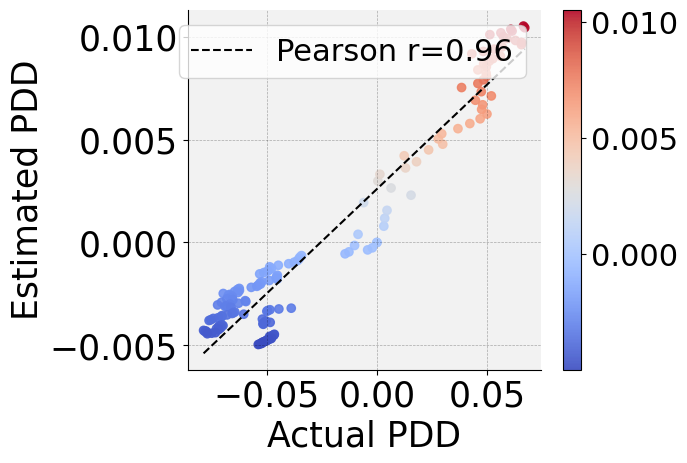

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default="bail", help='One dataset from income, bail, pokec1, and pokec2.')
args, unknown = parser.parse_known_args()
dataset_name = args.dataset

plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 22
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.default'] = 'regular'

final_sets = None
final_sets2 = None

if dataset_name == 'income':
    final_sets = np.load('1final_sets_income.npy', allow_pickle=True).item()
    final_sets2 = np.load('imp_final_sets_income.npy', allow_pickle=True).item()
elif dataset_name == 'bail':
    final_sets = np.load('1final_sets_bail.npy', allow_pickle=True).item() # CRITICAL CHECK WHY IS THERE NO FINAL SETS 1????
    final_sets2 = np.load('imp_final_sets_bail.npy', allow_pickle=True).item()
elif dataset_name == 'pokec1':
    final_sets = np.load('1final_sets_pokec1.npy', allow_pickle=True).item()
    final_sets2 = np.load('imp_final_sets_pokec1.npy', allow_pickle=True).item()
elif dataset_name == 'pokec2':
    final_sets = np.load('1final_sets_pokec2.npy', allow_pickle=True).item()
    final_sets2 = np.load('imp_final_sets_pokec2.npy', allow_pickle=True).item()

influence_approximation = final_sets['influence_approximation']
fair_cost_records = final_sets['fair_cost_records']

influence_approximation.extend(final_sets2['influence_approximation'])
fair_cost_records.extend(final_sets2['fair_cost_records'])

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.patch.set_facecolor("gray")
ax1.patch.set_alpha(0.1)

x = [item - fair_cost_records[0] for item in fair_cost_records]
y = influence_approximation

plt.scatter(x, y, c=y, cmap='coolwarm', alpha=0.9)
plt.xlabel("X")
plt.ylabel("Y")

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

plt.grid(True)
plt.grid(color='black', linestyle='--', linewidth=0.5, alpha=0.3)

linear_model=np.polyfit(x,y,1)
linear_model_fn=np.poly1d(linear_model)
max1 = np.array(x).max()
min1 = np.array(x).min()
x_s=np.arange(min1, max1, 1e-6)
plt.plot(x_s,linear_model_fn(x_s), color="black", linestyle='--', label="Pearson r=" + str(round(r_value, 2)))
plt.ylabel(r'Estimated PDD', fontdict={'family' : 'Times New Roman', 'size'   : 25})
plt.xlabel(r'Actual PDD', fontdict={'family' : 'Times New Roman', 'size'   : 25})
plt.yticks(fontproperties = 'Times New Roman', size = 25)
plt.xticks(fontproperties = 'Times New Roman', size = 25)
plt.legend(prop={'family' : 'Times New Roman', 'size'   : 22})
plt.colorbar()
plt.subplots_adjust(left = 0.21, right = 0.9, bottom = 0.18, top = 0.93)
plt.show()